## Synthetic Full Tensor Gravity Gradiometry

In [8]:
# Import the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
import tensorweave as tw

# Set device
device = "cpu"
dtype = torch.float32

In [9]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../additional_utils/Fonts/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Plotting params
# RCParams
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-5, 5]

# OPTIONAL CUSTOM COLORMAP
import matplotlib.colors as mcolors

# Define the colors extracted manually from the curlew
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

### High resolution Ground Truth

Read the high resolution data and use the grid to define the points at which the low resolution grid will be interpolated.

In [10]:
# High resolution dataset
full_dataset_hr = np.load("../Datasets/synthetic_highres.npy")
# Coordinates (m)
xyz_hr = full_dataset_hr[:, (0, 1, 2)]
# Gravitational acceleration (mGal)
g_hr = full_dataset_hr[:, (3, 4, 5)]
# Gradiometry (Eotvos)
ftg_hr = full_dataset_hr[:, 6:]

# Interpolation grid from the high res dataset
xvec = xyz_hr[:, 0]
yvec = xyz_hr[:, 1]
zvec = xyz_hr[:, 2]
grid = np.c_[xvec, yvec, zvec]
actv = np.ones_like(xvec).astype(bool)
shape = (65, 65)
x_mesh = xvec.reshape(shape)[:, 0]
y_mesh = yvec.reshape(shape)[0]

### Low Resolution Flight Lines

We use flight lines with high inline sampling and low crossline sampling (200 m) to mimic acquisition conditions.

In [11]:
# Low resolution dataset
full_dataset = np.load("../Datasets/synthetic_lowres_200.npy")
# Coordinates
xyz = full_dataset[:, (0, 1, 2)]
# Gravitational acceleration
g = full_dataset[:, (3, 4, 5)]
# Gradiometry
ftg = full_dataset[:, 6:]
# Add some noise to the data
ftg = tw.add_ftg_noise_by_snr(ftg, snr_db=[20, 18, 18, 15, 17, 19])

# Also load the density model and plot a cross-section for visualization!
syn_model = np.load("../Datasets/synthetic_model.npy")
# Extract a Model Slice
model_slice_idx = syn_model[:, 2] == -140
plot_model = syn_model[model_slice_idx]
# For plotting
model_x = np.linspace(np.nanmin(syn_model[:, 0]), np.nanmax(syn_model[:, 0]), 120)
model_y = np.linspace(np.nanmin(syn_model[:, 1]), np.nanmax(syn_model[:, 1]), 120)

### Visualise the model and data!

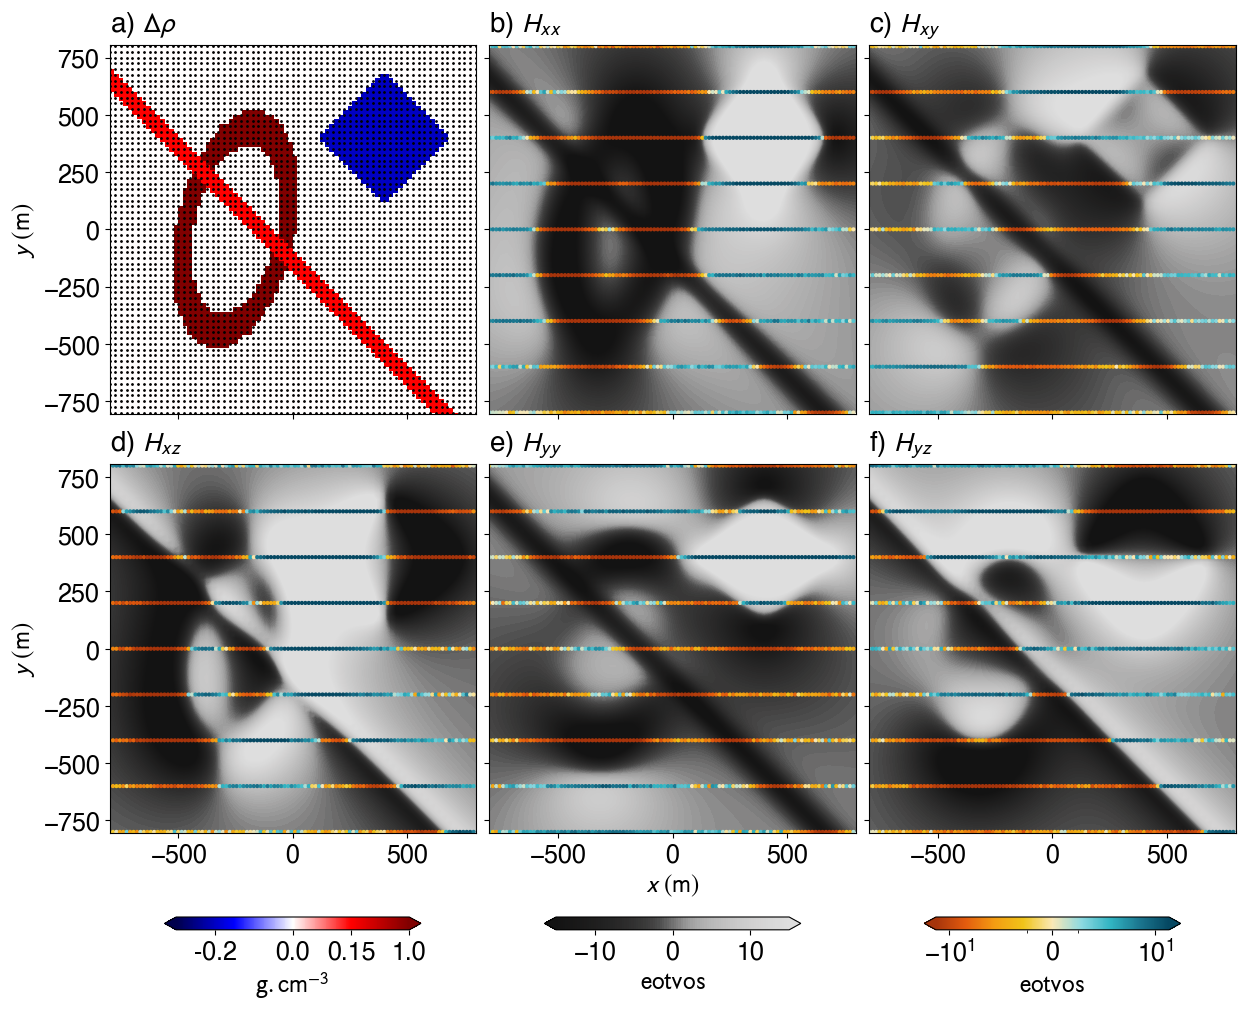

In [12]:
# Plot the data
fig, ax = plt.subplots(2, 3, figsize=(13, 10), sharex=True, sharey=True, layout="compressed")
a_ = ax.ravel()
# Set the labels and titles
labels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) "]
titles = [r"$\Delta \rho$", r"$H_{xx}$", r"$H_{xy}$",
          r"$H_{xz}$", r"$H_{yy}$", r"$H_{yz}$"]
cmap = cmr.get_sub_cmap('cmr.neutral', 0.1, 0.9)

# High resolution grid with contourf()
_ = [a_[i].contourf(x_mesh, y_mesh, ftg_hr[:, i-1].reshape(shape).T, np.linspace(-15, 15, 100), norm=mcolors.SymLogNorm(1, 0.3), extend="both", cmap=cmap) for i in range(1, 6)]
m = _[-1]
m_model = a_[0].pcolormesh(model_x, model_y, plot_model[:, -1].reshape((120, 120)), vmin=-0.3, vmax=0.3, cmap="seismic")

# Make the colorbars
plt.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(-0.3, 0.3), cmap="seismic"), ax=a_[3], orientation="horizontal",
             shrink=0.7, ticks=[-0.2, 0.0, 0.15, 0.3], label=r"$\mathrm{g.cm^{-3}}$", extend="both").set_ticklabels(["-0.2", "0.0", "0.15", "1.0"])

# Plot the high resolution grid
a_[0].scatter(xvec, yvec, s=1, c="k")

# Make the plot pretty :-)
_ = [a_[i].set_ylim([-805, 805]) for i in range(len(ax.ravel()))]
_ = [a_[i].set_xlim([-800, 800]) for i in range(len(ax.ravel()))]

# Low resolution data with scatter()
_ = [a_[i].scatter(xyz[:,0], xyz[:, 1], s=4, c=ftg[:, i-1], norm=mcolors.SymLogNorm(1, 0.3, -15, 15), cmap=curlew_cont) for i in range(1, 6)]
m_ = _[-1]
_ = [a_[i].set_title(labels[i] + titles[i], pad=10, loc="left") for i in range(len(titles))]
_ = [ax_.set_aspect('equal') for ax_ in a_]
plt.colorbar(mappable=m, ax=ax.ravel()[4], orientation="horizontal", ticks=[-10, 0, 10], label=r"$\mathrm{eotvos}$", shrink=0.7)
plt.colorbar(mappable=m_, ax=ax.ravel()[5], orientation="horizontal", ticks=[-10, 0, 10], label=r"$\mathrm{eotvos}$", shrink=0.7, extend="both")

# Set the labels
a_[0].set_ylabel(r"$y\ (\mathrm{m})$")
a_[3].set_ylabel(r"$y\ (\mathrm{m})$")
a_[4].set_xlabel(r"$x\ (\mathrm{m})$")

# Save the figure (optional)
plt.savefig("./Figures/synthetic_model_data.png", dpi=350)
plt.show()

In [16]:
# Prepare the data for training
xyz_perturb = np.copy(xyz)
# Perturb the points in the z direction (To allow faster model convergence)
xyz_perturb[:, 2] += (np.random.randn(xyz.shape[0]))
# Convert to torch Tensors
xyz_torch = torch.tensor(xyz_perturb, device=device, dtype=dtype)
b_torch = torch.tensor(ftg, device=device, dtype=dtype)  # xx, xy, xz, yz, zz

# Preload active grid points (for Laplacian loss) on GPU
active_grid_points_np = np.c_[xvec, yvec, zvec][actv]  # shape: (N_active, 3)
active_grid_points = torch.tensor(active_grid_points_np, device=device, dtype=dtype)

In [17]:
# Initialise
model = tw.NeuralFourierField(num_fourier_features=16, length_scales=[2e2, 4e2, 1e3], learnable=True, potential_scale=5e6,
                           device=device, hidden_layers=[256, 256], activation=nn.Tanh(), seed=404)

# Fit!
losses, lapl_counts = model.fit(xyz_torch, b_torch, active_grid_points, epochs=400, lr=1e-2, lap_spacing=(250, 80, 6, 1, 30),
                                lap_samples=1000, chunk_size=1024)

# Extract the losses
grad_losses = losses[:, 0]
lapl_losses = losses[:, 1]

Training: 100%|██████████| 400/400 [00:40<00:00,  9.79it/s, loss=1.532501, data=1.249881, lap=0.282620, lr=0.000687, lap_ns=262, stall=14]


In [19]:
# Create a dictionary
synthetic_model = {"model": model, "grad_losses": grad_losses, "lapl_losses": lapl_losses, "lapl_counts": lapl_counts}

# Pickle the file and store!
import joblib
_ = joblib.dump(synthetic_model, "../Models/synthetic_model.pkl")

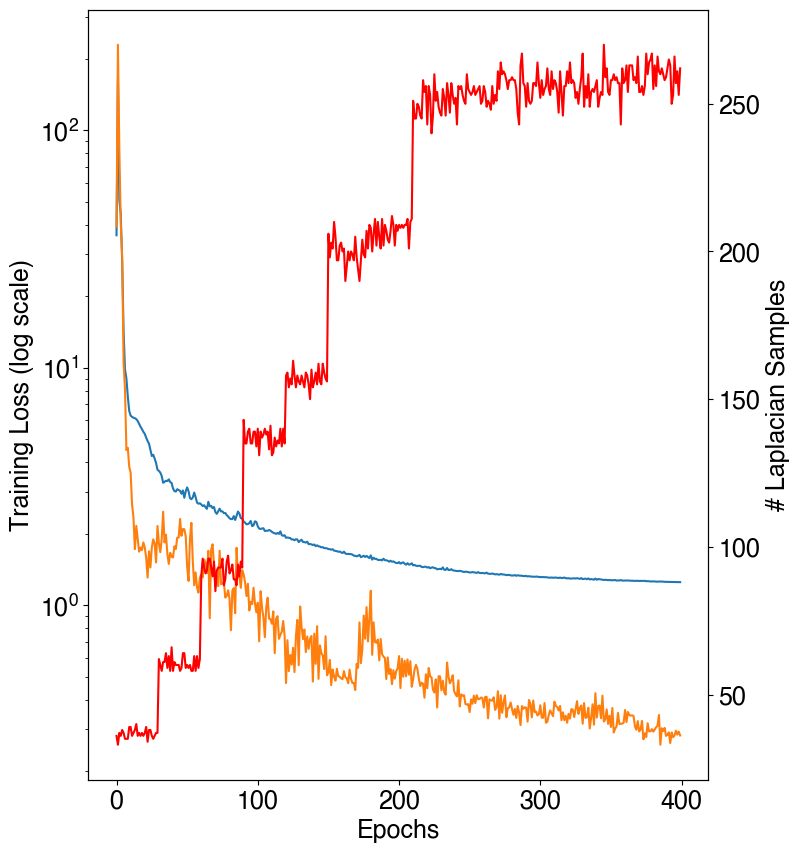

In [20]:
# Plot the loss curve
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
ax.semilogy(grad_losses)
ax.semilogy(lapl_losses)
# Make a twin axis to plot the laplacian sample counts
ax_ = ax.twinx()
ax_.plot(lapl_counts, c="r")
# Labels
ax_.set_ylabel('# Laplacian Samples')
ax.set_ylabel("Training Loss (log scale)")
ax.set_xlabel("Epochs")

plt.show()

In [21]:
# Evaluate!
_, _, predicted_hessian = tw.compute_hessian_eval(model, active_grid_points, chunk_size=2048)
# Create an array to hold gradient components over the full grid
hess_components = np.full((xvec.shape[0], 6), np.nan)
hess_components[actv] = predicted_hessian.cpu().detach().numpy().reshape(-1, 9)[:, (0, 1, 2, 4, 5, 8)] # xx, xy, xz, yy, yz, zz

### Other techniques

For comparison, we use the Radial Basis Function (RBF) Interpolator and the Clough Tocher Minimum Curvature (CT) Interpolator.

In [22]:
# Compute the RBF and CT
from scipy.interpolate import RBFInterpolator as RBF
from scipy.interpolate import CloughTocher2DInterpolator as CT

# Initialise the RBF
rbf_func = RBF(xyz[:, :-1], ftg, neighbors=300, smoothing=5e3)
rbf_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
rbf_grid[actv] = rbf_func(grid[actv, :-1])

# Initialise the CT
ct_func = CT(xyz[:, :-1], ftg)
ct_grid = np.full((xvec.shape[0], 6), np.nan)
# Evaluate
ct_grid[actv] = ct_func(grid[actv, :-1])

In [23]:
# Plotting indices and parameters
# Select indices corresponding to H_xx, H_xy, H_xz for display (adjust if needed)
idx = [0, 1, 2]
# Labels for NF, RBF and CT
nf_labels = [r"$H^{\mathrm{NF}}_{xx}$", r"$H^{\mathrm{NF}}_{xy}$", r"$H^{\mathrm{NF}}_{xz}$",
             r"$H^{\mathrm{NF}}_{yy}$", r"$H^{\mathrm{NF}}_{yz}$", r"$H^{\mathrm{NF}}_{zz}$"]
rbf_labels = [r"$H^{\mathrm{RBF}}_{xx}$", r"$H^{\mathrm{RBF}}_{xy}$", r"$H^{\mathrm{RBF}}_{xz}$",
              r"$H^{\mathrm{RBF}}_{yy}$", r"$H^{\mathrm{RBF}}_{yz}$", r"$H^{\mathrm{RBF}}_{zz}$"]
ct_labels = [r"$H^{\mathrm{CT}}_{xx}$", r"$H^{\mathrm{CT}}_{xy}$", r"$H^{\mathrm{CT}}_{xz}$",
             r"$H^{\mathrm{CT}}_{yy}$", r"$H^{\mathrm{CT}}_{yz}$", r"$H^{\mathrm{CT}}_{zz}$"]
# Colormap capping
cmax = 15

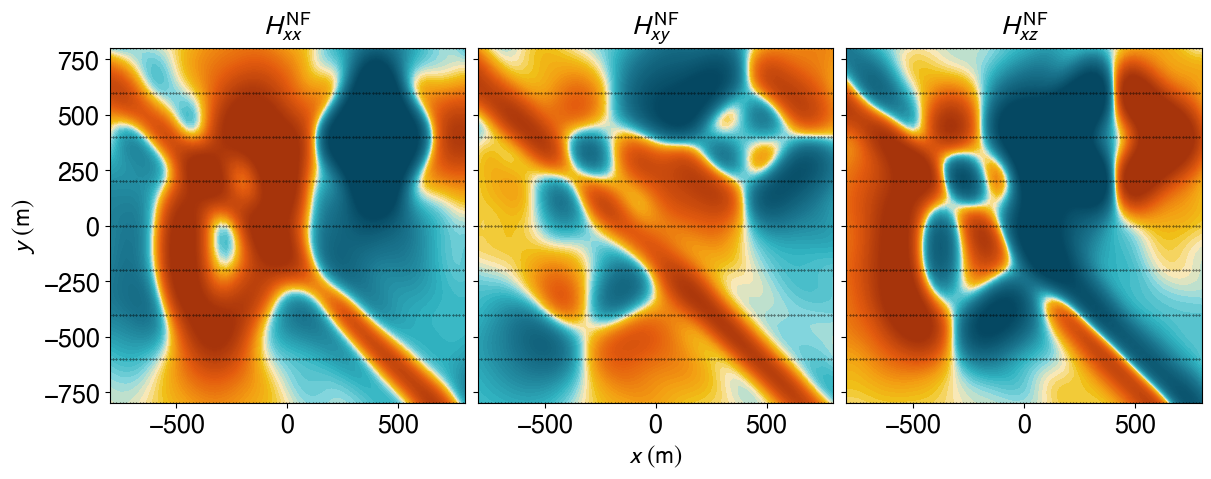

In [24]:
# Plot the NF!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, hess_components[:, idx[i]].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(nf_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()

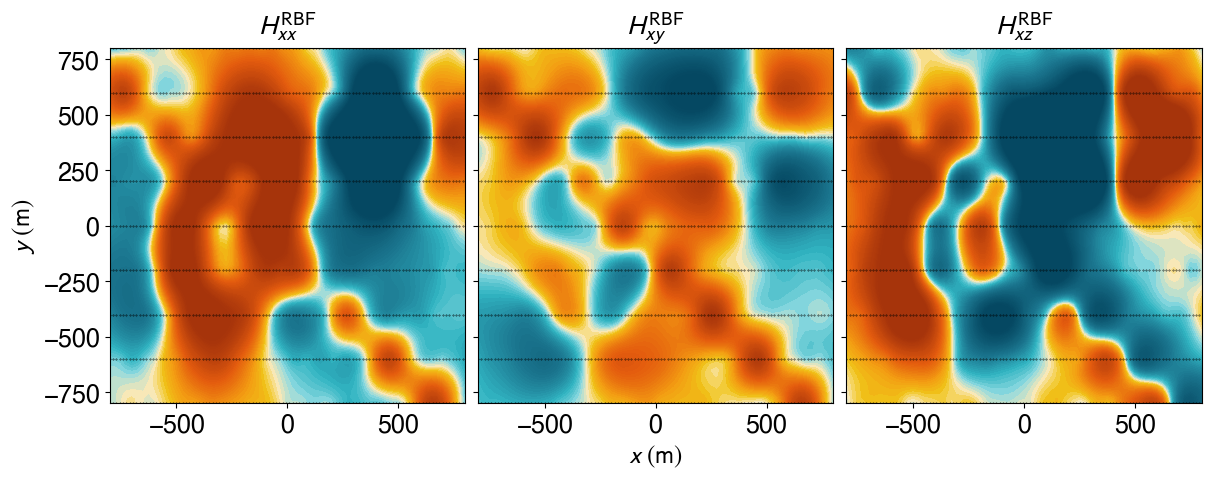

In [25]:
# Plot the RBF!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, rbf_grid[:, idx[i]].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(rbf_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()

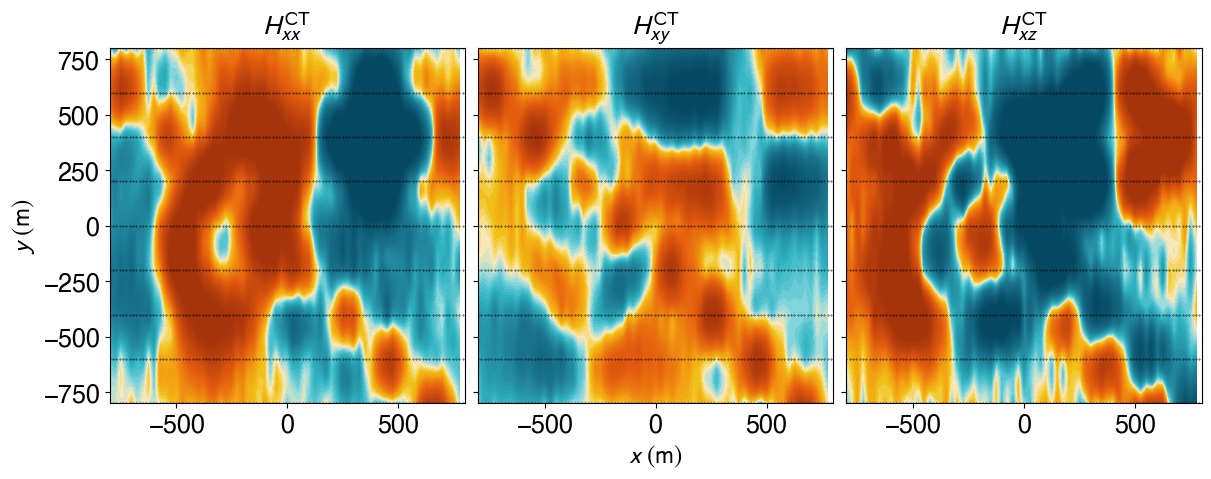

In [26]:
# Plot the CT!
fig, ax = plt.subplots(1, 3, figsize=(12, 6), layout="compressed", sharex=True, sharey=True)

# Contour plots
for i in range(3):
    ax[i].contourf(
        x_mesh, y_mesh, ct_grid[:, idx[i]].reshape(shape).T,
        levels=np.linspace(-cmax, cmax, 100),
        norm=mcolors.SymLogNorm(1, 0.3),
        extend="both", cmap=curlew_cont
    )
    ax[i].set_title(ct_labels[idx[i]], pad=10)

# Axis labels and aspect ratio
ax[0].set_ylabel(r"$y\ (\mathrm{m})$")
ax[1].set_xlabel(r"$x\ (\mathrm{m})$")
for a in ax:
    a.set_aspect("equal")
    
# Optionally overlay known points for context
_ = [a_.scatter(xyz[:, 0], xyz[:, 1], s=0.1, c='k') for a_ in ax]

plt.show()

### Compare accuracy metrics across components!

In [27]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Clough-Tocher Minimum Curvature
ct_r2 = np.array([r2_score(ftg_hr[:, k].reshape(shape).T[:, :-1].ravel(), ct_grid[:, k].reshape(shape).T[:, :-1].ravel()) for k in range(6)])
ct_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T[:, :-1], ct_grid[:, k].reshape(shape).T[:, :-1], data_range=1) for k in range(6)])
ct_mse = np.array([mean_squared_error(ftg_hr[:, k].reshape(shape).T[:, :-1].ravel(), ct_grid[:, k].reshape(shape).T[:, :-1].ravel()) for k in range(6)])

# RBF
rbf_r2 = np.array([r2_score(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])
rbf_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T, rbf_grid[:, k].reshape(shape).T, data_range=1) for k in range(6)])
rbf_mse = np.array([mean_squared_error(ftg_hr[:, k], rbf_grid[:, k]) for k in range(6)])

# TensorWeave
nf_r2 = np.array([r2_score(ftg_hr[:, k], hess_components[:, k]) for k in range(6)])
nf_ss = np.array([ssim(ftg_hr[:, k].reshape(shape).T, hess_components[:, k].reshape(shape).T, data_range=1) for k in range(6)])
nf_mse = np.array([mean_squared_error(ftg_hr[:, k], hess_components[:, k]) for k in range(6)])


In [28]:
# Display the means
print(f"Clough Tocher Minimum Curvature:\n R\u00b2 Score = {ct_r2.mean():.3f}, SSIM = {ct_ss.mean():.3f}, MSE = {ct_mse.mean():.3f}")
print(f"Radial Basis Functions:\n R\u00b2 Score = {rbf_r2.mean():.3f}, SSIM = {rbf_ss.mean():.3f}, MSE = {rbf_mse.mean():.3f}")
print(f"TensorWeave:\n R\u00b2 Score = {nf_r2.mean():.3f}, SSIM = {nf_ss.mean():.3f}, MSE = {nf_mse.mean():.3f}")

Clough Tocher Minimum Curvature:
 R² Score = 0.884, SSIM = 0.596, MSE = 12.389
Radial Basis Functions:
 R² Score = 0.921, SSIM = 0.693, MSE = 8.144
TensorWeave:
 R² Score = 0.984, SSIM = 0.891, MSE = 1.861
